# Predicting Youtube View Count in 2007/2008

### Introduction

After being acquired by Google in 2006, Youtube obtained a rapid growth in popularity resulting in a growing community. The goal of this project is to use the data of 2007 to predict the view of videos in 2008. We will be using datasets from https://netsg.cs.sfu.ca/youtubedata/. The dataset uses a crawler to obtained video API and scrape the webpage for the remaining information.


In [ ]:
## TODO
-explain variables
-variable selection


### Methods

In [67]:
# Setup
library(tidyverse)

#### Wrangling data
We decide to immediately remove some of the variables presented in the datasets. This included `video ID` and `related IDs` because these variables appear to be unique to the videos itself and not affect video views as a whole. `uploader`,`age`, and `category` are not included as well 

In [ ]:
## Loading Table 0007
table0007 <- read.delim("0.txt", header = FALSE, sep = "\t", dec = ".")

table0007done <- table0[-c(1,2,3,4,10:29)]
colnames(table0007done) <- c("length","views","rate","ratings","comments")

## Loading Table 0107
table0107 <- read.delim("1.txt", header = FALSE, sep = "\t", dec = ".")
head(table1)

table1done <- table1[-c(1,2,3,4,10:29)]
head(table1done)
colnames(table1done) <- c("length","views","rate","ratings","comments")
head(table1done)

## Loading Table 0207
table0207 <- read.delim("2.txt", header = FALSE, sep = "\t", dec = ".")
head(table2)

table2done <- table2[-c(1,2,3,4,10:29)]
head(table2done)
colnames(table2done) <- c("length","views","rate","ratings","comments")
head(table2done)

## Loading Table 0307
table3 <- read.delim("3.txt", header = FALSE, sep = "\t", dec = ".")
head(table3)

table3done <- table3[-c(1,2,3,4,10:29)]
head(table3done)
colnames(table3done) <- c("length","views","rate","ratings","comments")
head(table3done)

## Combine Into 1 datatable and export to a single table

datatable2008 <- rbind(table0done,table1done,table2done, table3done)
tail(datatable2008)

write.table(datatable2008, file = "datatable2008.txt", sep = "\t",
            row.names = FALSE, col.names = TRUE)
 
## Loading Table 0008
table0 <- read.delim("0.txt", header = FALSE, sep = "\t", dec = ".")
head(table0)

table0done <- table0[-c(1,2,3,4,10:29)]
head(table0done)
colnames(table0done) <- c("length","views","rate","ratings","comments")
head(table0done)

## Loading Table 0108
table1 <- read.delim("1.txt", header = FALSE, sep = "\t", dec = ".")
head(table1)

table1done <- table1[-c(1,2,3,4,10:29)]
head(table1done)
colnames(table1done) <- c("length","views","rate","ratings","comments")
head(table1done)
## Loading Table 0208
table2 <- read.delim("2.txt", header = FALSE, sep = "\t", dec = ".")
head(table2)

table2done <- table2[-c(1,2,3,4,10:29)]
head(table2done)
colnames(table2done) <- c("length","views","rate","ratings","comments")
head(table2done)

## Loading Table 0308
table3 <- read.delim("3.txt", header = FALSE, sep = "\t", dec = ".")
head(table3)

table3done <- table3[-c(1,2,3,4,10:29)]
head(table3done)
colnames(table3done) <- c("length","views","rate","ratings","comments")
head(table3done)


## Combine Into 1 datatable

datatable2007 <- rbind(table0done,table1done,table2done, table3done)
head(datatable2007)

In [31]:
#Read the data
data2007 <- read.csv("data/datatable2007.txt",sep="")
na.omit(is.na(data2007))
is.data.frame(data2007)

length,views,rate,ratings,comments
FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE


[1] TRUE

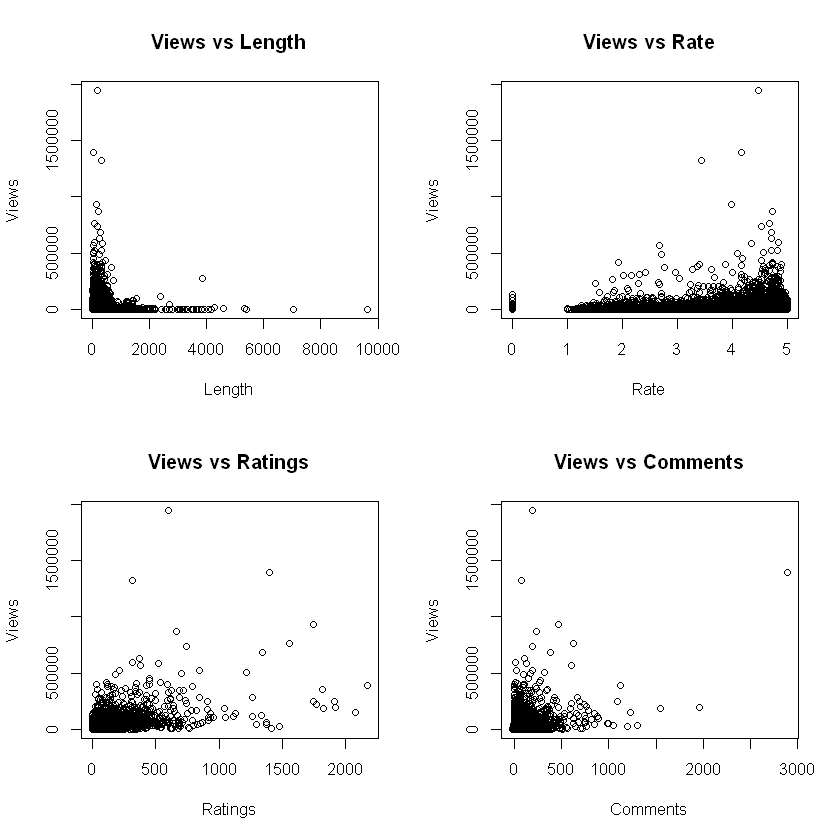

In [10]:
#Observe the explanatory variables individually against the predictor, views.
par(mfrow=c(2,2))
plot(data2007$length,data2007$views, ylab = 'Views', xlab = 'Length', main = 'Views vs Length')
plot(data2007$rate,data2007$views, ylab = 'Views', xlab = 'Rate', main = 'Views vs Rate')
plot(data2007$ratings,data2007$views, ylab = 'Views', xlab = 'Ratings', main = 'Views vs Ratings')
plot(data2007$comments,data2007$views, ylab = 'Views', xlab = 'Comments', main = 'Views vs Comments')

In [62]:
rownum <- sample(1:nrow(data2007), 0.75*nrow(data2007))
train <- data2007[rownum,]
test <- data2007[-rownum,]

[1] 6528.14

It appears that the explanatory variables do not have a linear relationship with the predictor variable.

In [49]:
# Perform linear regression
mod <- lm(views~.,train)
summary(mod)


Call:
lm(formula = views ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-392891   -2783   -1454    -209 1770727 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1548.0894   206.9578   7.480 7.55e-14 ***
length        -4.7790     0.4813  -9.930  < 2e-16 ***
rate         303.3353    49.8441   6.086 1.17e-09 ***
ratings      271.6657     2.5530 106.411  < 2e-16 ***
comments      38.7290     3.7194  10.413  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 19590 on 46568 degrees of freedom
  (79 observations deleted due to missingness)
Multiple R-squared:  0.3735,	Adjusted R-squared:  0.3735 
F-statistic:  6942 on 4 and 46568 DF,  p-value: < 2.2e-16


Although there is a low p-value for the coefficients, the adjusted R-squared value is not particularly high and an extremely high standard error.

In [86]:
#Lets predict the number of views
prediction <- predict(mod,test)
summary(prediction)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -15781    1973    3418    6525    6197  635024      21 

[1] TRUE

[1] 15551

[1] 15551

In [89]:
#Calculate the RMSE
prediction <- na.omit(prediction)
test$views <- na.omit(test$views)
rmse <- sqrt(mean((test$views - prediction)^2))
rmse

[1] 18143.52

[1] 18143.52

It seems like the residual mean squared error is enormously high, which provides a good indication that this linear regression model is not well fitted.